## Wildfire Proximity and Property Values - ECON 323 Project

>**Author**
   - Sheldon Birkett
   - Student ID: 31089329

**Abstract**

This project studies the effect of housing proximity to wildfires on property values. Specifically, the analysis is limited to wildfires caused by lightning in California to minimize endogeneity issues (i.e. limited to natural wildfires not caused by people). The fire year of 2008 was chosen as there was a rapid increase in the number of wildfires and intensity for that year and provides a stark "treatment" constrast to fire years of 2007 and 2009. Using OLS, quantile regressions, and partially linear regressions the study finds no significant effect of housing proximity to wildfires on property values for homes located within 100km from a wildfire.

In [1]:
import sys
'geopandas' in sys.modules

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import qeds
import datetime as dt

import math
import statistics
import scipy.stats

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

import geopandas as gdp
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon

import descartes

from shapely import speedups

speedups.disable()

import sqlite3

import contextily as ctx

Import **Zillow Home Value Index (ZHVI)** data which reflects the typical value for homes in the 35th to 65th percentile range. This is considered mid-tier range of property values and is considered closets to the standard definition of a typical home.  For more information on Zillow data see [Zillow Housing Data](https://www.zillow.com/research/data/). This data includes single family residences (SFR), Condo, and Co-op housing.

When I downloaded the data from the [Zillow website](https://www.zillow.com/research/data/) I specified the smoothed and seasonally adjusted dataset at the ZIP code level of geography. RegionName is associated with the ZIP code of the housing unit.

In [4]:
df = pd.read_csv(r"C:\Users\sheld\Documents\ECON 323 - Data Science\quantecon-notebooks-datascience\problem_sets\Zip_zhvi_uc_sfrcondo_tier.csv", index_col = False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30230 entries, 0 to 30229
Columns: 307 entries, RegionID to 2020-10-31
dtypes: float64(298), int64(3), object(6)
memory usage: 70.8+ MB


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
#read in shape file for United States Zip Codes
zip_code_us = gdp.read_file(r"C:\Users\sheld\Documents\ECON 323 - Data Science\quantecon-notebooks-datascience\problem_sets\tl_2019_us_zcta510.shp")


In [8]:
df = df[df["State"]=="CA"].dropna(axis=0) #only selected california and dropped rows which had missing values for property values
df = df.rename(columns = {"RegionName":"ZIP_CODE"})
zip_code_us = zip_code_us.rename(columns = {"ZCTA5CE10":"ZIP_CODE"})
zip_code_us = zip_code_us.astype({"ZIP_CODE": int})

In [9]:
#merge house price data and shapefile on zip codes
dfm = pd.merge(df, zip_code_us, how = "left", on = "ZIP_CODE")
#convert to geopandas dataframe
sdf_dfm = gdp.GeoDataFrame(dfm, geometry = dfm.geometry)

Import **Fire Program Analysis fire-occurenance database (FPA FOD)** from **[Kaggle](https://www.kaggle.com/rtatman/188-million-us-wildfires)**. This is a spatial database of of wildfires that occurred in the United States from 1992 to 2015.  The wildfire records were acquired from the reporting systems of federal, state, and local fire organizations. The following core data elements were required for records to be included in this data publication: discovery date, final fire size, and a point location at least as precise as Public Land Survey System (PLSS) section (1-square mile grid). For more information visit: **[Kaggle](https://www.kaggle.com/rtatman/188-million-us-wildfires)**.

For some assistance with this database I referenced **[Predicting Wildfires](https://www.andrewmahon.info/blog/predicting-wildfires-1)**. 

In [10]:
input_filename = r'C:\Users\sheld\Documents\ECON 323 - Data Science\quantecon-notebooks-datascience\problem_sets\FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)

query = '''
    SELECT
        NWCG_REPORTING_AGENCY,
        NWCG_REPORTING_UNIT_ID,
        NWCG_REPORTING_UNIT_NAME,
        FIRE_NAME,
        COMPLEX_NAME,
        FIRE_YEAR,
        DISCOVERY_DATE,
        DISCOVERY_DOY,
        DISCOVERY_TIME,
        STAT_CAUSE_CODE,
        STAT_CAUSE_DESCR,
        CONT_DATE,
        CONT_DOY,
        CONT_TIME,
        FIRE_SIZE,
        FIRE_SIZE_CLASS,
        LATITUDE,
        LONGITUDE,
        OWNER_CODE,
        OWNER_DESCR,
        STATE,
        COUNTY
    FROM
        Fires;
'''

raw_df = pd.read_sql_query(query, conn)

In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   NWCG_REPORTING_AGENCY     object 
 1   NWCG_REPORTING_UNIT_ID    object 
 2   NWCG_REPORTING_UNIT_NAME  object 
 3   FIRE_NAME                 object 
 4   COMPLEX_NAME              object 
 5   FIRE_YEAR                 int64  
 6   DISCOVERY_DATE            float64
 7   DISCOVERY_DOY             int64  
 8   DISCOVERY_TIME            object 
 9   STAT_CAUSE_CODE           float64
 10  STAT_CAUSE_DESCR          object 
 11  CONT_DATE                 float64
 12  CONT_DOY                  float64
 13  CONT_TIME                 object 
 14  FIRE_SIZE                 float64
 15  FIRE_SIZE_CLASS           object 
 16  LATITUDE                  float64
 17  LONGITUDE                 float64
 18  OWNER_CODE                float64
 19  OWNER_DESCR               object 
 20  STATE                   

In [12]:
df_strip = raw_df.copy()[[
    'FIRE_NAME', 
    'FIRE_YEAR',
    'FIRE_SIZE', 
    'FIRE_SIZE_CLASS', 
    'STAT_CAUSE_CODE',
    'STAT_CAUSE_DESCR',
    'OWNER_CODE',
    'OWNER_DESCR',
    'DISCOVERY_DATE',
    'DISCOVERY_DOY',
    'LATITUDE',
    'LONGITUDE',
    'STATE'
]]
df_strip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FIRE_NAME         object 
 1   FIRE_YEAR         int64  
 2   FIRE_SIZE         float64
 3   FIRE_SIZE_CLASS   object 
 4   STAT_CAUSE_CODE   float64
 5   STAT_CAUSE_DESCR  object 
 6   OWNER_CODE        float64
 7   OWNER_DESCR       object 
 8   DISCOVERY_DATE    float64
 9   DISCOVERY_DOY     int64  
 10  LATITUDE          float64
 11  LONGITUDE         float64
 12  STATE             object 
dtypes: float64(6), int64(2), object(5)
memory usage: 186.5+ MB


In [13]:
df_strip["FIRE_COORDINATES"] = list(zip(df_strip.LATITUDE, df_strip.LONGITUDE))

In [14]:
df_strip["COMBINED_DATE"] = df_strip["FIRE_YEAR"]*1000 + df_strip["DISCOVERY_DOY"]
df_strip["FIRE_DATE"] = pd.to_datetime(df_strip["COMBINED_DATE"], format= '%Y%j')
df_strip["FIRE_DATE_0"] = df_strip["FIRE_DATE"].dt.strftime('%Y-%m')
#added a "FIRE_DATE_0" Column to Dataframe, "FIREDATE" is the YYYY/MM the fire was discovered (to match with Zillow Data).

In [15]:
df_strip["FIRE_COORDINATES"] = df_strip["FIRE_COORDINATES"].apply(Point)
gdf_fire = gdp.GeoDataFrame(df_strip, geometry="FIRE_COORDINATES")
gdf_fire = gdf_fire[(gdf_fire["STATE"]=="CA") & (gdf_fire["FIRE_DATE_0"] >= "1996-01")]
#only select fires in California for 1996 onwards to match with Zillow Data

In [16]:
cause_mapping = gdf_fire.groupby(["STAT_CAUSE_CODE", "STAT_CAUSE_DESCR"]).size().to_frame().drop(0, axis = 1)

In [17]:
cause_mapping.head(100)

Empty DataFrame
Columns: []
Index: [(1.0, Lightning), (2.0, Equipment Use), (3.0, Smoking), (4.0, Campfire), (5.0, Debris Burning), (6.0, Railroad), (7.0, Arson), (8.0, Children), (9.0, Miscellaneous), (10.0, Fireworks), (11.0, Powerline), (12.0, Structure), (13.0, Missing/Undefined)]

We can see that there are many causes of fire. I am only interested in natural wildfires so I will only select fires caused by lightning to reduce endogeneity issues. Note that this choice has the potential downside of not capturing the effect of non-natural fires on property values. However, by including non-natural wildfires it is increasing the risk of endogeneity in the model. This choice is purely a judgement call and further research would need to be conducted to assess the merits of including and/or excluding non-natural fires.

In [18]:
gdf_fire_natural = gdf_fire[(gdf_fire["STAT_CAUSE_DESCR"]=="Lightning")]

In [19]:
gdf_fire_natural["COUNT"] = 1
hist_class = gdf_fire_natural.groupby(["FIRE_SIZE_CLASS"]).count()
hist_class = hist_class["COUNT"]

C:\Users\sheld\anaconda3\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


The **[United States Geological Survey (USGS)](https://www.usgs.gov/ecosystems/lcsp/fire-danger-forecast/map-large-fire-probability)** defines a large fire as fire that burns for more than 100 acres. Given the size classification provided by the **[National Wildfire Coordinating Group](https://www.nwcg.gov/term/glossary/size-class-of-fire)** I will limit my analysis to those wildfires becuase small wildfires are most likely easily estinguished and don't pose much of a threat to properties on a large scale.

In [20]:
gdf_fire_natural_california = gdf_fire_natural.copy()[(gdf_fire_natural["FIRE_SIZE_CLASS"] == "D")|(gdf_fire_natural["FIRE_SIZE_CLASS"] == "E")|(gdf_fire_natural["FIRE_SIZE_CLASS"] == "F")|(gdf_fire_natural["FIRE_SIZE_CLASS"] == "G")].drop(columns = {"STAT_CAUSE_CODE","STAT_CAUSE_DESCR", "DISCOVERY_DATE","DISCOVERY_DOY","STATE","COMBINED_DATE","COUNT", "FIRE_DATE"}).rename(columns = {"FIRE_DATE_0":"FIRE_DATE"})
gdf_fire_natural_california = gdf_fire_natural_california.rename(columns={"FIRE_DATE":"DATE"}).set_index("DATE")

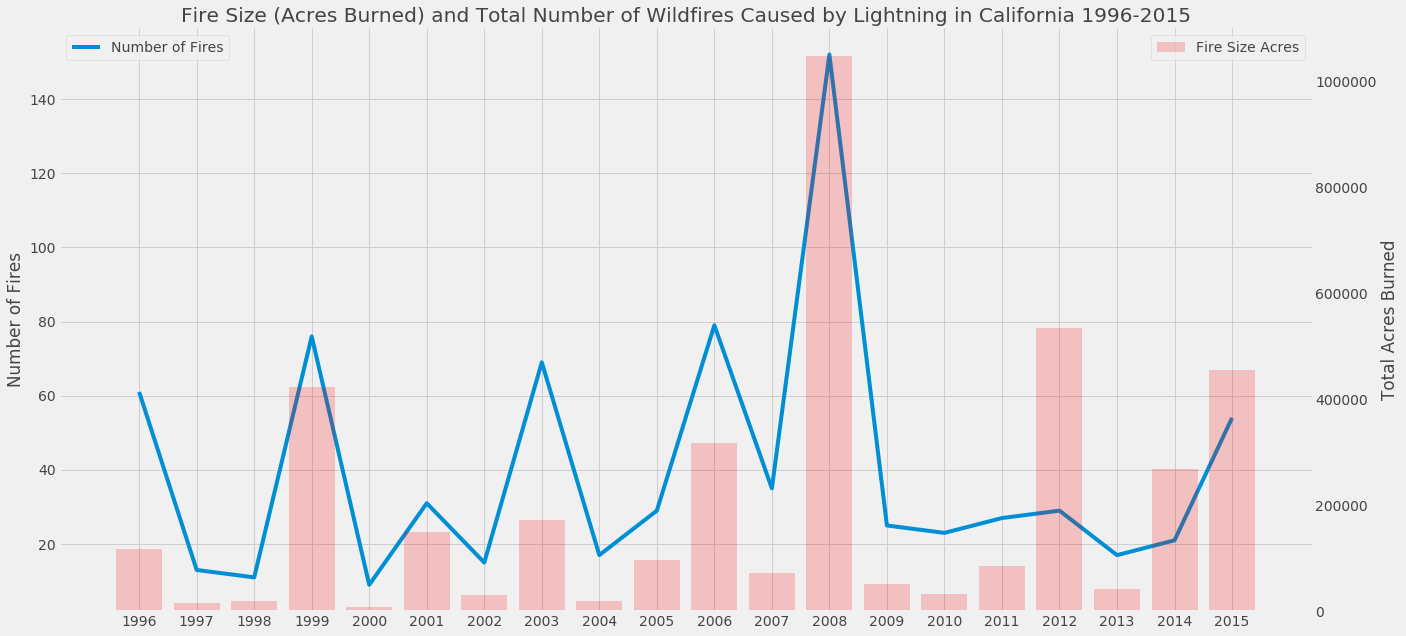

In [21]:
gdf_fire_natural_c = gdf_fire_natural_california.copy()

gdf_fire_natural_c["Count"] = 1
gdf_fire_natural_c = gdf_fire_natural_c.groupby(["FIRE_YEAR"]).sum()

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots()

ax_2 = ax.twinx()

ax.plot(gdf_fire_natural_c.Count, label = "Number of Fires")

ax_2.bar(gdf_fire_natural_c.index, gdf_fire_natural_c.FIRE_SIZE, alpha = 0.2, color = 'red', label = "Fire Size Acres")

ax_2.grid(b = False)

ax.set_title('Fire Size (Acres Burned) and Total Number of Wildfires Caused by Lightning in California 1996-2015')
ax.set_ylabel('Number of Fires')
ax_2.set_ylabel('Total Acres Burned')

x_ticks = np.arange(1996, 2016, 1)
plt.xticks(x_ticks)

ax.legend(loc = "upper left")
ax_2.legend()


As seen in the graph above 2008 looks like it had a record number of lightning fires and record number of fire sizes in comparison to the other years. I will use 2008 as a treatment year given the record number of wildfires. A quick google search also shows that the 2008 was one of the most devistating wildfire years in [California](https://en.wikipedia.org/wiki/2008_California_wildfires#:~:text=The%202008%20California%20wildfire%20season,each%20year%20prior%20to%202007.&text=%22One%20never%20has%20resources%20for%201%2C700%20fires).

Back to Zillow Data. Preparing the data for merging with Wildfire Data.

In [22]:
sdf_dfm["INTPTLAT10"] = sdf_dfm["INTPTLAT10"].astype(str)
sdf_dfm["INTPTLON10"] = sdf_dfm["INTPTLON10"].astype(str)

In [23]:
sdf_dfm["INTPTLAT10"] = sdf_dfm["INTPTLAT10"].str.replace("+", "")
sdf_dfm["INTPTLON10"] = sdf_dfm["INTPTLON10"].str.replace("+","")

In [24]:
sdf_dfm["INTPTLAT10"] = sdf_dfm["INTPTLAT10"].replace("nan", np.NaN)
sdf_dfm["INTPTLON10"] = sdf_dfm["INTPTLON10"].replace("nan", np.NaN)

In [25]:
sdf_dfm = sdf_dfm.dropna(axis=0, how='all', subset = ["INTPTLAT10","INTPTLON10"]) 
#drop rows with NaN for selected columns of longitude and latitude

In [26]:
sdf_dfm["INTPTLAT10"] = pd.to_numeric(sdf_dfm["INTPTLAT10"], errors = "coerce")
sdf_dfm["INTPTLON10"] = pd.to_numeric(sdf_dfm["INTPTLON10"], errors = "coerce")

In [27]:
sdf_dfm["HOUSE_COORDINATES"] = list(zip(sdf_dfm.INTPTLAT10, sdf_dfm.INTPTLON10))

## Map Visualizations

In [28]:
import dash 
import dash_core_components as dcc
import plotly.graph_objs as go
import plotly.express as px
from math import radians, cos, sin, asin, sqrt

In [29]:
gdf_fire_natural_california["text"] = '<br>Fire Name:' + gdf_fire_natural_california["FIRE_NAME"] + '<br>Fire Size:' + (gdf_fire_natural_california["FIRE_SIZE"].astype(str)) +' Acres' + '<br>Year/Month of Fire (YYYY/MM): ' + (gdf_fire_natural_california.index.astype(str))
colors = "salmon"
scale = 100

In [30]:
fig = go.Figure()

gdf_fire_natural_california_sub = gdf_fire_natural_california[0:793]
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = gdf_fire_natural_california_sub["LONGITUDE"],
    lat = gdf_fire_natural_california_sub["LATITUDE"],
    text = gdf_fire_natural_california_sub["text"],
            marker = dict(
        size = gdf_fire_natural_california_sub["FIRE_SIZE"]/scale,
        color = colors,
        line_color = 'black',
        line_width = 0.5,
        sizemode = 'area'
    ),
    name = 'Wildfires'.format()))
    
fig.update_layout(
    title_text = "California Natural Wildfires 1996-2015",
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'rgb(217,217,217)',
    )
)

fig.update_geos(fitbounds = "locations")


fig.show()

In [31]:
sdf_dfm["text"] = "<br>City: " + sdf_dfm["City"] + "<br>Metro: " + sdf_dfm["Metro"] + '<br> House Price 2008-01: $'+ sdf_dfm["2008-01-31"].astype(str)


In [32]:
sdf_dfm_sup = sdf_dfm[0:1115]

fig = go.Figure(data = go.Scattergeo(
    locationmode = 'USA-states',
    lon = sdf_dfm_sup["INTPTLON10"],
    lat = sdf_dfm_sup["INTPTLAT10"],
    text = sdf_dfm_sup["text"],
    mode = 'markers',
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True, 
        autocolorscale = False,
        symbol = 'circle',
        line = dict(
            width = 1,
            color = 'rgba(102,102,102)'),
        colorscale = 'Viridis',
        cmin = 0,
        color = sdf_dfm_sup["2008-01-31"],
        cmax = sdf_dfm_sup["2008-01-31"].max(),
        colorbar_title = "House Prices <br> January 2008"
    )))
    
fig.update_layout(
    title_text = "House Prices January 2008",
    showlegend = False,
    geo = dict(
        scope = 'usa',
        landcolor = 'rgb(217,217,217)',
    )
)

fig.update_geos(fitbounds = "locations")

fig.show()

In [33]:
sdf_dfm["text"] = "<br>City: " + sdf_dfm["City"] + "<br>Metro: " + sdf_dfm["Metro"] + '<br> House Price 2009-01: $'+ sdf_dfm["2009-01-31"].astype(str)


In [34]:
sdf_dfm_sup = sdf_dfm[0:1115]

fig = go.Figure(data = go.Scattergeo(
    locationmode = 'USA-states',
    lon = sdf_dfm_sup["INTPTLON10"],
    lat = sdf_dfm_sup["INTPTLAT10"],
    text = sdf_dfm_sup["text"],
    mode = 'markers',
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True, 
        autocolorscale = False,
        symbol = 'circle',
        line = dict(
            width = 1,
            color = 'rgba(102,102,102)'),
        colorscale = 'Viridis',
        cmin = 0,
        color = sdf_dfm_sup["2009-01-31"],
        cmax = sdf_dfm_sup["2009-01-31"].max(),
        colorbar_title = "House Prices <br> January 2009"
    )))
    
fig.update_layout(
    title_text = "House Prices January 2009",
    showlegend = False,
    geo = dict(
        scope = 'usa',
        landcolor = 'rgb(217,217,217)',
    )
)

fig.update_geos(fitbounds = "locations")

fig.show()

## Preparation for Regressions

To calculate the distance between each home and wildfire I will be using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula#:~:text=The%20haversine%20formula%20determines%20the,and%20angles%20of%20spherical%20triangles). 

 - $ \Phi_1, \Phi_2 $ latitude of point 1 and latitude of point 2 in radians. 
 - $ \lambda_1, \lambda_2$ longitude of point 1 and longitude of point 2 in radians. 
 
Haversine: 

$$ d = 2 r \arcsin \left[\sqrt{\sin^2\left( \frac{\Phi_2 - \Phi_1}{2} \right)  + \cos(\Phi_1) \cos(\Phi_2) \sin^2 \left( \frac{\lambda_2 - \lambda_1}{2} \right)}\right] $$

Python formula adopted from [here](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points). 

In [35]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [36]:
#for each house in the Zillow dataset I need to calculate the distance to each fire. 
sdf_dfm0 = sdf_dfm[["ZIP_CODE", "City", "Metro", "CountyName", 
                    "2008-01-31","2008-02-29", "2008-03-31", "2008-04-30", "2008-05-31", 
                    "2008-06-30", "2008-07-31", "2008-08-31", "2008-09-30", "2008-10-31", 
                    "2008-11-30", "2008-12-31", "INTPTLAT10", "INTPTLON10"]]

In [37]:
sdf_dfm0["Year"] = 2008

C:\Users\sheld\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
fire_2008 = gdf_fire_natural_california[gdf_fire_natural_california["FIRE_YEAR"] == 2008]

In [39]:
fire_2008 = fire_2008.rename(columns = {"FIRE_YEAR":"Year"})

In [40]:
sdf_fire_2008 = pd.merge(sdf_dfm0, fire_2008 , on="Year", how="left")

In [41]:
sdf_fire_2008["Distance"] = haversine(sdf_fire_2008.INTPTLON10, sdf_fire_2008.INTPTLAT10, sdf_fire_2008.LONGITUDE, sdf_fire_2008.LATITUDE)

In [42]:
sdf_fire_2008_dist100 = sdf_fire_2008[sdf_fire_2008["Distance"] <= 100]

In [43]:
sdf_dfm_price_07_09 = sdf_dfm[["ZIP_CODE","2007-01-31","2007-02-28", 
                               "2007-03-31", "2007-04-30", "2007-05-31", "2007-06-30", 
                               "2007-07-31", "2007-08-31", "2007-09-30", "2007-10-31", 
                               "2007-11-30", "2007-12-31", "2009-01-31","2009-02-28", 
                               "2009-03-31","2009-04-30", "2009-05-31", "2009-06-30", 
                               "2009-07-31", "2009-08-31", "2009-09-30","2009-10-31", "2009-11-30", "2009-12-31"]]

In [44]:
Fire_2008_Prices_0708 = pd.merge(sdf_fire_2008_dist100, sdf_dfm_price_07_09, on="ZIP_CODE", how="left")
Fire_2008_Prices_0708 = Fire_2008_Prices_0708[["ZIP_CODE", "City", "Metro", "CountyName", "Year", "FIRE_NAME", 
                                               "FIRE_SIZE", "Distance", "2007-01-31","2007-02-28", "2007-03-31",
                                               "2007-04-30", "2007-05-31", "2007-06-30","2007-07-31", "2007-08-31", 
                                               "2007-09-30", "2007-10-31", "2007-11-30", "2007-12-31","2008-01-31",
                                               "2008-02-29", "2008-03-31", "2008-04-30", "2008-05-31","2008-06-30", 
                                               "2008-07-31", "2008-08-31", "2008-09-30", "2008-10-31","2008-11-30",
                                               "2008-12-31","2009-01-31","2009-02-28", "2009-03-31","2009-04-30", 
                                               "2009-05-31","2009-06-30","2009-07-31", "2009-08-31", "2009-09-30",
                                               "2009-10-31","2009-11-30", "2009-12-31"]]

## Partially Linear Regression

To estimate the effect of proximity to natural wildfires in 2008 on house prices in 2009 I will be using a partially linear regression. The choice of a partially linear regression is due to the fact that I have no concrete way of approximating $ X^\prime \beta$ given the 2008 recession. A partially linear regression gives me an automoated data driven process for estimating the transform of $x$ rather than arbitrarily choosing different functional forms for $X = T(x)$. 

The regression equation I will be estimating is: 

$$ y = \theta d + f(x) + \epsilon $$ 

Where $d$ is the distance to the nearest fire and $f(x)$ is an unknown function of house prices in 2007 and the magnitude of the fire perimeter. $y$ is the outcome variable of house prices in 2009. $\theta$ is the coefficient of interest which measures the effect of distance to wildfires on house prices. $\epsilon$ is the error term. One limitation of using partially linear regression for this study is that I don't have a wide set of controls to predict prices in the given dataset. Before using the partially linear regression I will also compute the results to the standard OLS and quantile regressions .

Code for the following sections has been adapted from Quant Econ DataScience lectures [Machine Learning in Economics](https://datascience.quantecon.org/applications/ml_in_economics.html) and [Regression](https://datascience.quantecon.org/applications/regression.html). 

In [45]:
def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

In [46]:
from patsy import dmatrices

In [47]:
Fire_2008_Prices_0708.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2222 entries, 0 to 2221
Data columns (total 44 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZIP_CODE    2222 non-null   int64  
 1   City        2222 non-null   object 
 2   Metro       2222 non-null   object 
 3   CountyName  2222 non-null   object 
 4   Year        2222 non-null   int64  
 5   FIRE_NAME   2180 non-null   object 
 6   FIRE_SIZE   2222 non-null   float64
 7   Distance    2222 non-null   float64
 8   2007-01-31  2222 non-null   float64
 9   2007-02-28  2222 non-null   float64
 10  2007-03-31  2222 non-null   float64
 11  2007-04-30  2222 non-null   float64
 12  2007-05-31  2222 non-null   float64
 13  2007-06-30  2222 non-null   float64
 14  2007-07-31  2222 non-null   float64
 15  2007-08-31  2222 non-null   float64
 16  2007-09-30  2222 non-null   float64
 17  2007-10-31  2222 non-null   float64
 18  2007-11-30  2222 non-null   float64
 19  2007-12-31  2222 non-null  

### OLS Regression

In [48]:
X = Fire_2008_Prices_0708.drop(["ZIP_CODE", "City", "Metro", "CountyName", "Year", "FIRE_NAME", "2008-01-31",
                                "2008-02-29", "2008-03-31", "2008-04-30", "2008-05-31","2008-06-30", 
                                "2008-07-31", "2008-08-31", "2008-09-30", "2008-10-31","2008-11-30",
                                "2008-12-31","2009-01-31","2009-02-28", "2009-03-31","2009-04-30", 
                                "2009-05-31","2009-06-30","2009-07-31", "2009-08-31", "2009-09-30",
                                "2009-10-31","2009-11-30", "2009-12-31"], axis = 1).copy()
X_mean = X[["2007-01-31","2007-02-28", "2007-03-31","2007-04-30", "2007-05-31", "2007-06-30",
            "2007-07-31", "2007-08-31","2007-09-30", "2007-10-31", "2007-11-30", "2007-12-31"]].mean(axis = 1)

In [49]:
# get mean house price for 2007
X = pd.concat([X, X_mean], axis = 1).drop(["2007-01-31","2007-02-28", "2007-03-31",
                                "2007-04-30", "2007-05-31", "2007-06-30","2007-07-31", "2007-08-31", 
                                "2007-09-30", "2007-10-31", "2007-11-30", "2007-12-31"], axis = 1).copy()
X = X.rename(columns = {0:"2007_House_Price"})

In [50]:
#get mean of outcome variable
y = Fire_2008_Prices_0708[["2009-01-31","2009-02-28", "2009-03-31","2009-04-30", "2009-05-31",
                          "2009-06-30","2009-07-31", "2009-08-31", "2009-09-30","2009-10-31","2009-11-30", "2009-12-31"]].mean(axis = 1).copy()
y = y.rename("2009_House_Price")
reg_data = pd.concat([X,y], axis = 1)
reg_data = reg_data[["2009_House_Price", "2007_House_Price", "FIRE_SIZE", "Distance"]]

Text(0, 0.5, 'Average House Price in 2009 (USD)')

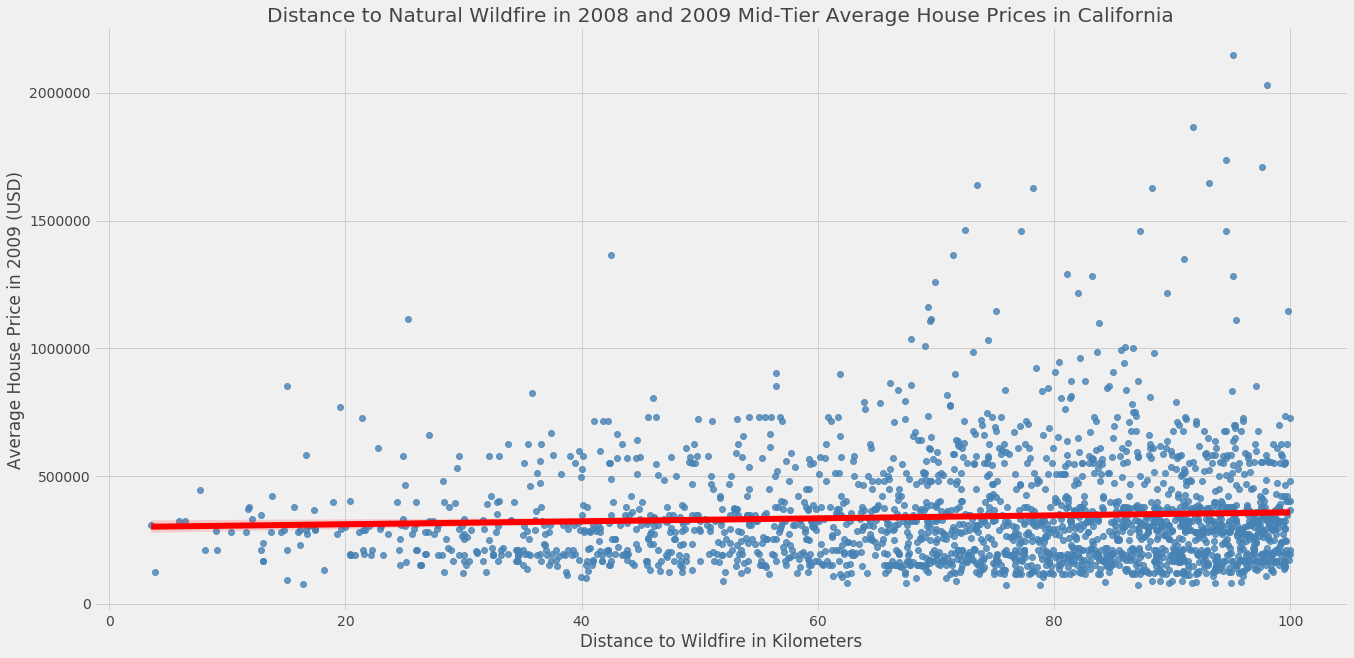

In [51]:
sns.regplot(data = reg_data, x = "Distance", y = "2009_House_Price", ci = 95, scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
plt.title("Distance to Natural Wildfire in 2008 and 2009 Mid-Tier Average House Prices in California")
plt.xlabel("Distance to Wildfire in Kilometers")
plt.ylabel("Average House Price in 2009 (USD)")

We can see that there is a clustering of homes between the 75km and 100km points and the regression line appears to be close to the averge house prices across distance to wildfires. Research by Stetler et al. (2010) found no effect of wildfires on property values 10 km away or more from the wildfires of interest. However, Stetler et al. (2010) did find a statistically significant effect between 5km and 10km away from a wildfire. Other literature limits homes of interest to 3.22km (2 miles) away from a wildfire as did Loomis (2004). For these reasons I will make a sensitivity plot of the parameters for distance from wildfires on the quantiles of the house price distribution by using a quantile regression.

In [52]:
# Run Multilinear Regression
lr_model = linear_model.LinearRegression()
#Fit Model
lr_model.fit(X, y)
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       2009_House_Price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 1.846e+04
Date:                Thu, 24 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:18:55   Log-Likelihood:                -26827.
No. Observations:                2222   AIC:                         5.366e+04
Df Residuals:                    2218   BIC:                         5.368e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.325e+04   3491.735  

As shown above the effect of distance to wildfires on property values in 2009 does not appear to be statistically significant, and the effect is going in a negative direction. The negative sign on the coefficient for distance is counter-intuitive as one would expect property values to increase as a house is farther away from a wildfire (i.e. lower risk of home burning down). This is an imprecise estimate as the literature tells us that property values of homes located more than 10km are not effected by wildfires and the effect should be positive.

In [53]:
#take natural log transform for house prices
logy = np.log(y)
logx = np.log(X["2007_House_Price"]).rename("LogHousePriceSeven")

In [54]:
X_logx = pd.concat([X, logx], axis = 1).drop(columns = {"2007_House_Price"})

In [55]:
# Run Multilinear Regression
lr_model = linear_model.LinearRegression()
#Fit Model
lr_model.fit(X_logx, logy)
X = sm.add_constant(X_logx)
results = sm.OLS(logy, X_logx).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       2009_House_Price   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.505e+04
Date:                Thu, 24 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:18:55   Log-Likelihood:                 1623.7
No. Observations:                2222   AIC:                            -3239.
Df Residuals:                    2218   BIC:                            -3217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.2016      0

In [56]:
reg_data_log = pd.concat([logy, X_logx], axis = 1)

Text(0, 0.5, '$log_{House Price (USD)}$')

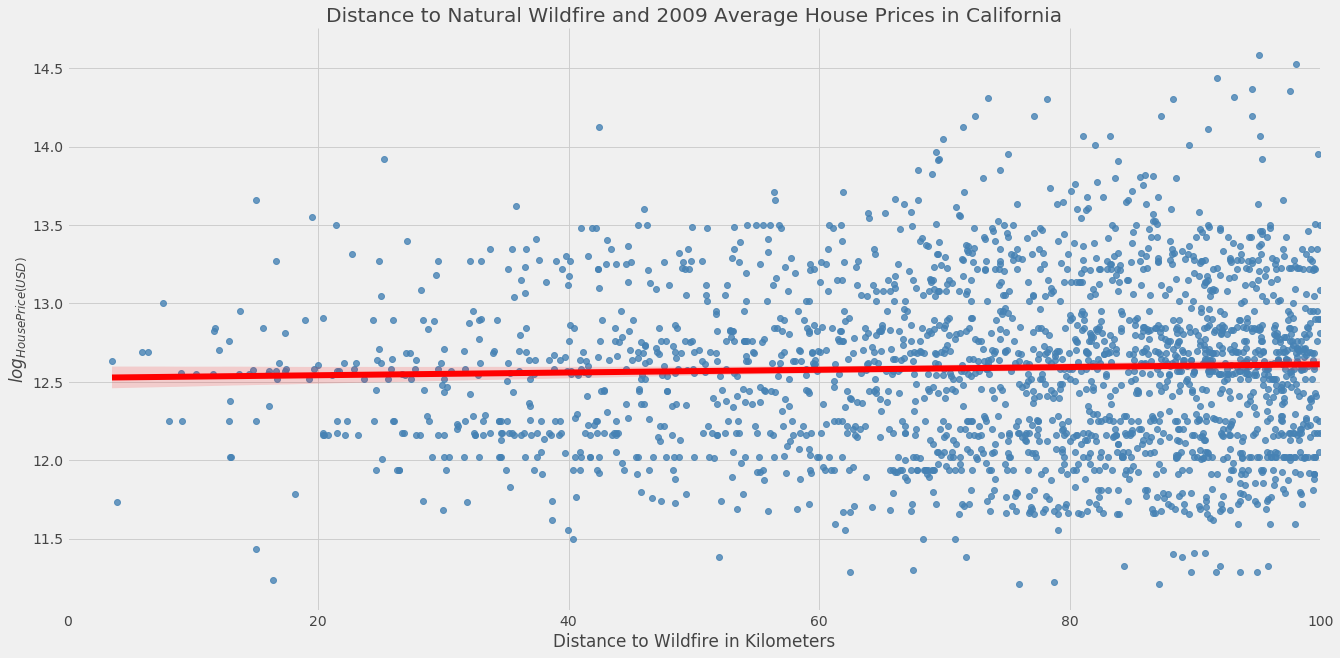

In [57]:
sns.regplot(data = reg_data_log, x = "Distance", y = "2009_House_Price", ci = 95, scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
plt.title("Distance to Natural Wildfire and 2009 Average House Prices in California")
plt.xlim((0, 100))
plt.xlabel("Distance to Wildfire in Kilometers")
plt.ylabel(r"$log_{House Price (USD)}$")

We can see above with the log transform of house prices, distance is now statistically significant but the effect is very small. For a unit increase in kilometers away from a wildfire there is a 0.004 percentage point decrease in property values. In the regression plot for only distance and log of house prices it appears the effect is positive, not negative as in the OLS regression results table. This suggests that our OLS model is imprecisely estimated. There is potentially strong multicollinearity between the dependent variable and 2007 house price control. I initally used the 2007 house prices as a control in-place of feature data (e.g. sqaure footage, bathrooms, acreage, etc.) that I do not have for the Zillow data.

## Quantile Regression

I reference resources from [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html) in coding this quantile regression and plots.

The Least Absolute Deviation is a special case of the quantile regression where $q = 0.5$ (median). 

In [58]:
reg_data = reg_data.rename(columns = {"2009_House_Price": "HousePriceNine", "2007_House_Price": "HousePriceSeven"})

In [59]:
reg_quant = smf.quantreg('HousePriceNine ~ Distance', reg_data)
result = reg_quant.fit(q = 0.5)
print(result.summary())

                         QuantReg Regression Results                          
Dep. Variable:         HousePriceNine   Pseudo R-squared:            0.0009338
Model:                       QuantReg   Bandwidth:                   5.810e+04
Method:                 Least Squares   Sparsity:                    3.528e+05
Date:                Thu, 24 Dec 2020   No. Observations:                 2222
Time:                        16:18:58   Df Residuals:                     2220
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.787e+05   1.32e+04     21.176      0.000    2.53e+05    3.05e+05
Distance     232.4120    173.804      1.337      0.181    -108.423     573.247


In [60]:
# define quantiles as a array for house prices
quantiles = np.arange(0.05, 0.96, 0.1)

#function to calculate regression for each quantile in quantiles with confidence intervals
def fit_model(q):
    result = reg_quant.fit(q=q)
    return [q, result.params["Intercept"], result.params["Distance"]] + result.conf_int().loc["Distance"].tolist()

#fit quantile models and make dataframe of results
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['quantile', 'Intercept', 'Distance', 'CILB', 'CIUB'])

#fit ols model wwith confidence intervals
ols = smf.ols('HousePriceNine ~ Distance', reg_data).fit()
ols_ci = ols.conf_int().loc["Distance"].tolist()


#create dictionary for ols results
ols = dict(Intercept = ols.params['Intercept'],
          Distance = ols.params['Distance'], 
          CILB = ols_ci[0], 
          CIUB = ols_ci[1])

print(models)
print(ols)

   quantile      Intercept     Distance        CILB         CIUB
0      0.05  142067.431447  -193.572013 -399.300379    12.156353
1      0.15  166649.975751    -2.478363 -210.355379   205.398652
2      0.25  195558.694673   -48.601058 -303.876361   206.674245
3      0.35  206185.549200   325.825641  -60.638903   712.290186
4      0.45  270908.214752   138.918300 -216.250567   494.087167
5      0.55  280777.831768   430.971880   89.921306   772.022454
6      0.65  303907.918367   617.138214  241.361214   992.915213
7      0.75  353391.810902   711.360552  -14.800610  1437.521715
8      0.85  448159.006635  1232.489118  472.329318  1992.648918
9      0.95  659915.535503   767.992909 -339.179064  1875.164882
{'Intercept': 299449.7208484186, 'Distance': 580.9108123307308, 'CILB': 164.1297408042958, 'CIUB': 997.6918838571657}


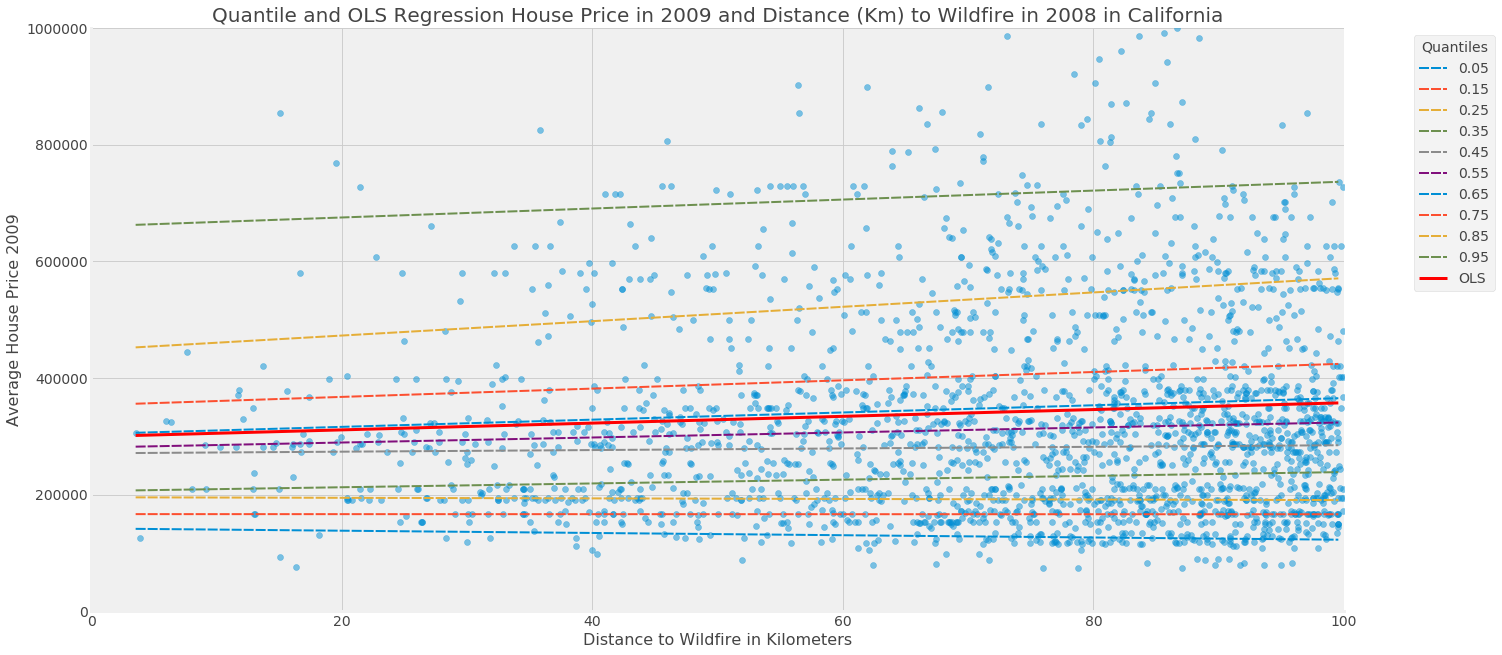

In [61]:
x = np.arange(reg_data.Distance.min(), reg_data.Distance.max(), 1)
get_y = lambda Intercept, Distance: Intercept + Distance * x

fig, ax = plt.subplots(figsize=(20, 10), facecolor = 'white')

for i in range(models.shape[0]):
    y = get_y(models.Intercept[i], models.Distance[i])
    ax.plot(x, y, linestyle=(0, (5,1)), label = models["quantile"][i].round(3), linewidth = 2)

y = get_y(ols['Intercept'], ols['Distance'])

ax.scatter(reg_data.Distance, reg_data.HousePriceNine, alpha= 0.5)
ax.plot(x, y, color='red', label='OLS', linewidth = 3)
ax.set_xlim((0, 100))
ax.set_ylim((0, 1000000))
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = "Quantiles")
ax.set_title("Quantile and OLS Regression House Price in 2009 and Distance (Km) to Wildfire in 2008 in California", fontsize = 20)
ax.set_xlabel('Distance to Wildfire in Kilometers', fontsize=16)
ax.set_ylabel('Average House Price 2009', fontsize=16);


We can see that homes farther away from a wildfire in 2008 had a higher price in 2009 than homes closer to a wildfire. Along the conditinal distribution of the dependent variable it appears the effect is more pronounced for homes above the 65th percentile. However, the Least Absolute Deviation quantile regression at the median shows distance is not statistically significant under a simple quantile regression. We can also see, as shown in the figure below, that the 0.05, 0.15, 0.25, 0.45 and 0.85 quantile regression estimates are outside of the confidence interval estimate for the OLS. This leads to suggest that the effect of proximity to wildfires on house prices is not constant across the distribution of house prices.

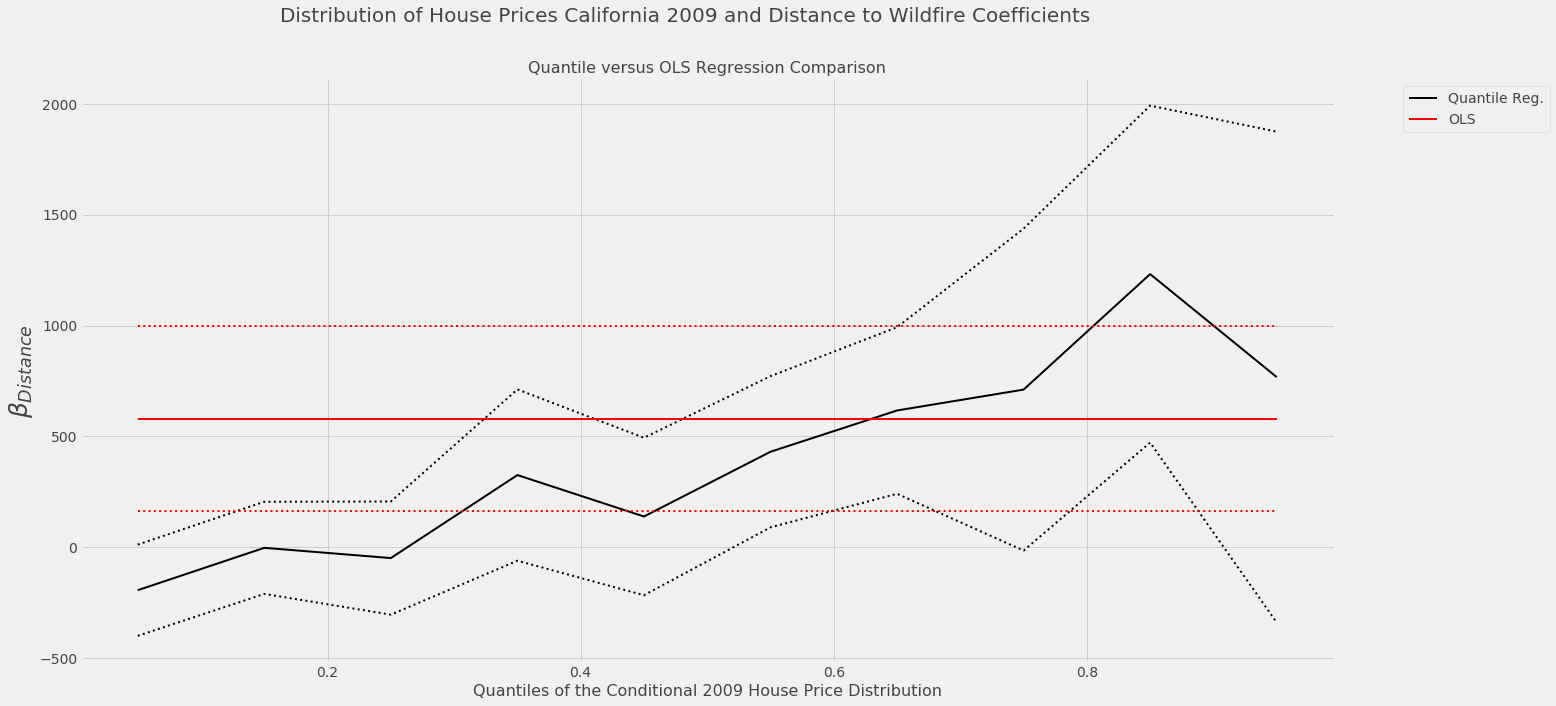

In [62]:
n = models.shape[0]
plt.figure(figsize = (20,10))
p1 = plt.plot(models["quantile"], models["Distance"], color='black', label='Quantile Reg.', linewidth = 2)
p2 = plt.plot(models["quantile"], models["CIUB"], linestyle='dotted', color='black', linewidth = 2)
p3 = plt.plot(models["quantile"], models["CILB"], linestyle='dotted', color='black', linewidth = 2)
p4 = plt.plot(models["quantile"], [ols['Distance']] * n, color='red', label='OLS', linewidth = 2)
p5 = plt.plot(models["quantile"], [ols['CILB']] * n, linestyle='dotted', color='red', linewidth = 2)
p6 = plt.plot(models["quantile"], [ols['CIUB']] * n, linestyle='dotted', color='red', linewidth = 2)
plt.title("Quantile versus OLS Regression Comparison", fontsize = 16)
plt.suptitle("Distribution of House Prices California 2009 and Distance to Wildfire Coefficients", fontsize = 20)
plt.ylabel(r'$\beta_{Distance}$', fontsize = 25)
plt.xlabel('Quantiles of the Conditional 2009 House Price Distribution', fontsize = 16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can also see from the graph above that OLS overestimates the effect on house prices for homes on the lower end of the house prices distribution and OLS underestimates the effect for homes on the upper end of the house price distribution. As a result OLS is not taking into account how proximity to wildires affects house prices accross the distribution. This is aligned with the findings in the literature (see, for example, Mueller and Loomis, 2014).  

### Log House Price Versions of Quantile Regressions

                         QuantReg Regression Results                          
Dep. Variable:         HousePriceNine   Pseudo R-squared:             0.001068
Model:                       QuantReg   Bandwidth:                      0.2022
Method:                 Least Squares   Sparsity:                        1.196
Date:                Thu, 24 Dec 2020   No. Observations:                 2222
Time:                        16:19:02   Df Residuals:                     2220
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.5385      0.045    280.941      0.000      12.451      12.626
Distance       0.0008      0.001      1.353      0.176      -0.000       0.002
   quantile  Intercept  Distance      CILB      CIUB
0      0.05  11.868507 -0.001498 -0.003010  0.000015
1      0.15  12.023652 -0

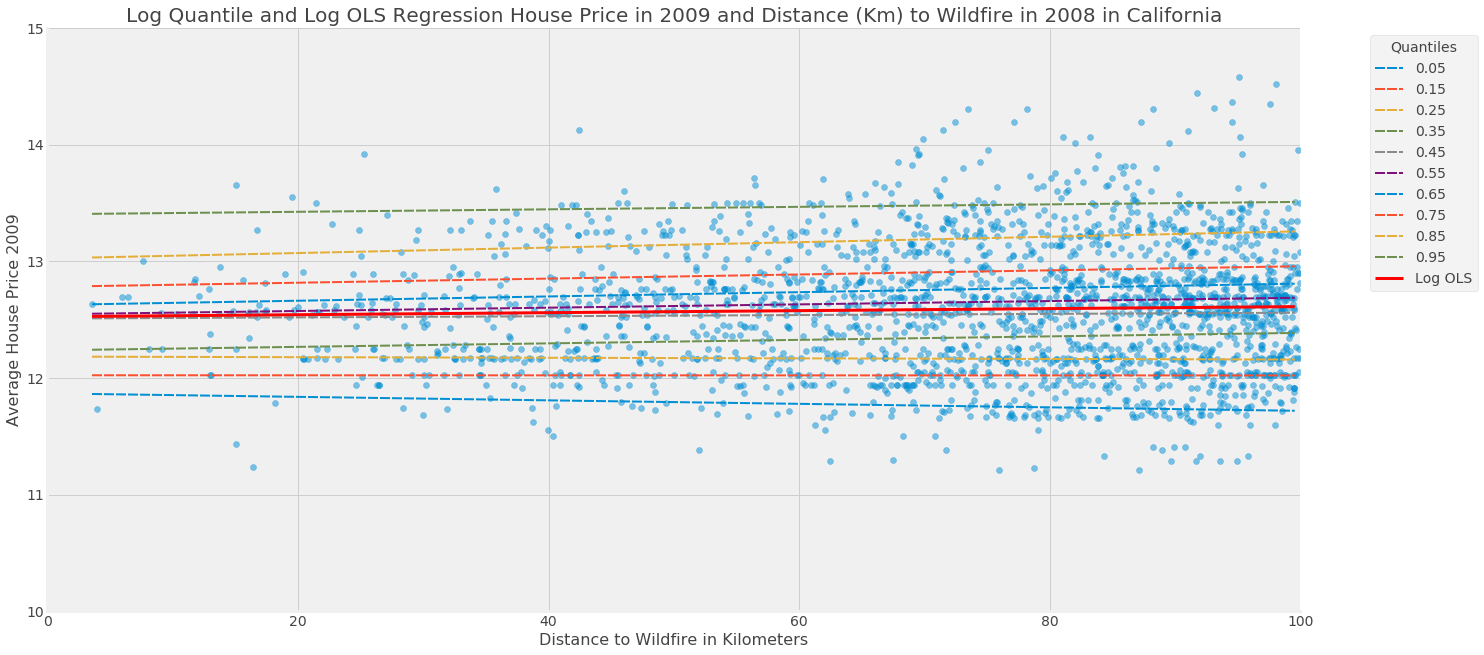

In [63]:
#making quantile reg for logs of house prices 
reg_data_log = reg_data_log.rename(columns = {"2009_House_Price": "HousePriceNine", "LogHousePriceSeven": "HousePriceSeven"})
reg_quant = smf.quantreg('HousePriceNine ~ Distance', reg_data_log)
result = reg_quant.fit(q = 0.5)
print(result.summary())

#fit log quantile models and make dataframe of results
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['quantile', 'Intercept', 'Distance', 'CILB', 'CIUB'])

#fit log ols model wwith confidence intervals
ols = smf.ols('HousePriceNine ~ Distance', reg_data_log).fit()
ols_ci = ols.conf_int().loc["Distance"].tolist()


#create dictionary for log ols results
ols = dict(Intercept = ols.params['Intercept'],
          Distance = ols.params['Distance'], 
          CILB = ols_ci[0], 
          CIUB = ols_ci[1])

print(models)
print(ols)

x = np.arange(reg_data_log.Distance.min(), reg_data_log.Distance.max(), 1)
get_y = lambda Intercept, Distance: Intercept + Distance * x

fig, ax = plt.subplots(figsize=(20, 10), facecolor = 'white')

for i in range(models.shape[0]):
    y = get_y(models.Intercept[i], models.Distance[i])
    ax.plot(x, y, linestyle=(0, (5,1)), label = models["quantile"][i].round(3), linewidth = 2)

y = get_y(ols['Intercept'], ols['Distance'])

ax.scatter(reg_data_log.Distance, reg_data_log.HousePriceNine, alpha= 0.5)
ax.plot(x, y, color='red', label='Log OLS', linewidth = 3)
ax.set_xlim((0, 100))
ax.set_ylim((10, 15))
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = "Quantiles")
ax.set_title("Log Quantile and Log OLS Regression House Price in 2009 and Distance (Km) to Wildfire in 2008 in California", fontsize = 20)
ax.set_xlabel('Distance to Wildfire in Kilometers', fontsize=16)
ax.set_ylabel('Average House Price 2009', fontsize=16);

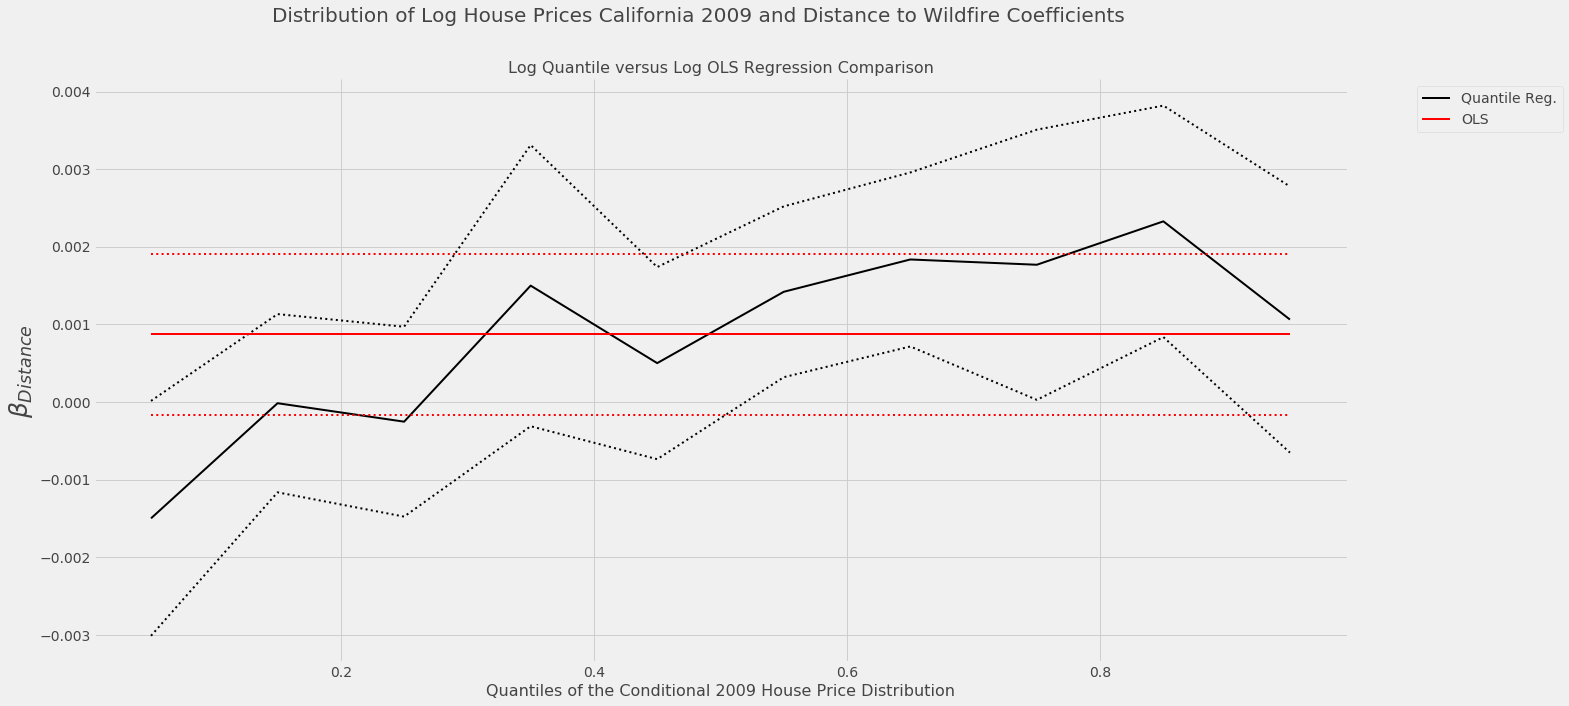

In [64]:
n = models.shape[0]
plt.figure(figsize = (20,10))
p1 = plt.plot(models["quantile"], models["Distance"], color='black', label='Quantile Reg.', linewidth = 2)
p2 = plt.plot(models["quantile"], models["CIUB"], linestyle='dotted', color='black', linewidth = 2)
p3 = plt.plot(models["quantile"], models["CILB"], linestyle='dotted', color='black', linewidth = 2)
p4 = plt.plot(models["quantile"], [ols['Distance']] * n, color='red', label='OLS', linewidth = 2)
p5 = plt.plot(models["quantile"], [ols['CILB']] * n, linestyle='dotted', color='red', linewidth = 2)
p6 = plt.plot(models["quantile"], [ols['CIUB']] * n, linestyle='dotted', color='red', linewidth = 2)
plt.title("Log Quantile versus Log OLS Regression Comparison", fontsize = 16)
plt.suptitle("Distribution of Log House Prices California 2009 and Distance to Wildfire Coefficients", fontsize = 20)
plt.ylabel(r'$\beta_{Distance}$', fontsize = 25)
plt.xlabel('Quantiles of the Conditional 2009 House Price Distribution', fontsize = 16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Again estimates are still imprecise and the effect across the house price distribution is not as dramatic. Log OLS appears to better estimates the log quantile regression, as shown in the figure above. However, not many conclusions can be drawn from these regressions as I do not have an adeqaute number of features for the given households in the Zillow data. In addition there is multicollinearity present in the OLS model in having 2007 house prices as a proxy for feature controls.  

### Partially Linear Model

I will be using a partially linear lasso model to estimate $\hat{\theta}$ becuase I am primarily interested in ensuring $\hat{\theta}$ has good statistcial properties for interpreting the effect of wildfire proximity on house prices. The method below assumes the parameters are linear in $d$ (distance) but not in $x$ (house prices). Becuase of the 2008 recession I have reason to believe that house prices between 2007 and 2009 followed a non-linear trend and may be a reason why OLS is not a precise estimator. In addition, the estimates above I have made many arbitrary decisions on the functional form of the controls $X\prime \beta$ which opens up a possibility of omitted variable bias. In the estimates below I use an oracle property to estimate $f(x)$. However, the choice of regularization parameter in the lasso regression is still arbitrary, but I am making less arbitrary decisions about the functional form of the regression in comparison to OLS and quantile regressions. I am also assuming that the residual is not related to any of the covariates $\mathbb{E} [\epsilon | d, x ] = 0 $ given that I am capturing many of the housing features embedded in the 2007 house prices. This is a bold assumption, but the goal of this project is not to prove causality but to show how $d$ and $y$ are related. To estimate the effect of proximity to wildfires on house prices in 2009 I will predict $y$ (log house price 2009) and $d$ (distance to wildfire) from $x$ (i.e. log house price 2007 and wildfire size in 2008) with cross-validation. I will split the data into 3 $k$ subsets, and for each subset $j^{th}$, the method will train the models to predict $y$ and $d$ using the other $2$ ($k-1$) subsets which results in $p_{-j}^y(x)$ and $p_{-j}^d(x)$. Then for $y_i$ in the $j^{th}$ subset the method will use the other $k-1$ subsets to predict $\hat{y}_i$ and $\hat{d}_i$. Partial out $x$ we get: 

$$ y_i = \theta d_i + f(x_i) + \epsilon $$

$$ \hat{y}_i = \theta \hat{d}_i + f(x_i) + \epsilon $$

$$ y_i - \hat{y}_i = \hat{\theta} (d_i - \hat{d}_i) $$ 

$$ \tilde{y}_i = \hat{\theta} \tilde{d}_i $$

where $\hat{\theta}$ is the estimated coefficient of interest for $\tilde{d}_i$.

In [65]:
regpl = "HousePriceNine + Distance ~ FIRE_SIZE + HousePriceSeven"
yd, X = dmatrices(regpl, reg_data_log)

In [66]:
distance = yd[:,1]
loghousepricenine = yd[:,0]

Note: selection of regularization parameter $\alpha$ here is arbitrary.

In [67]:
# select regularization parameter for lasso regression 
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,loghousepricenine)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,distance)

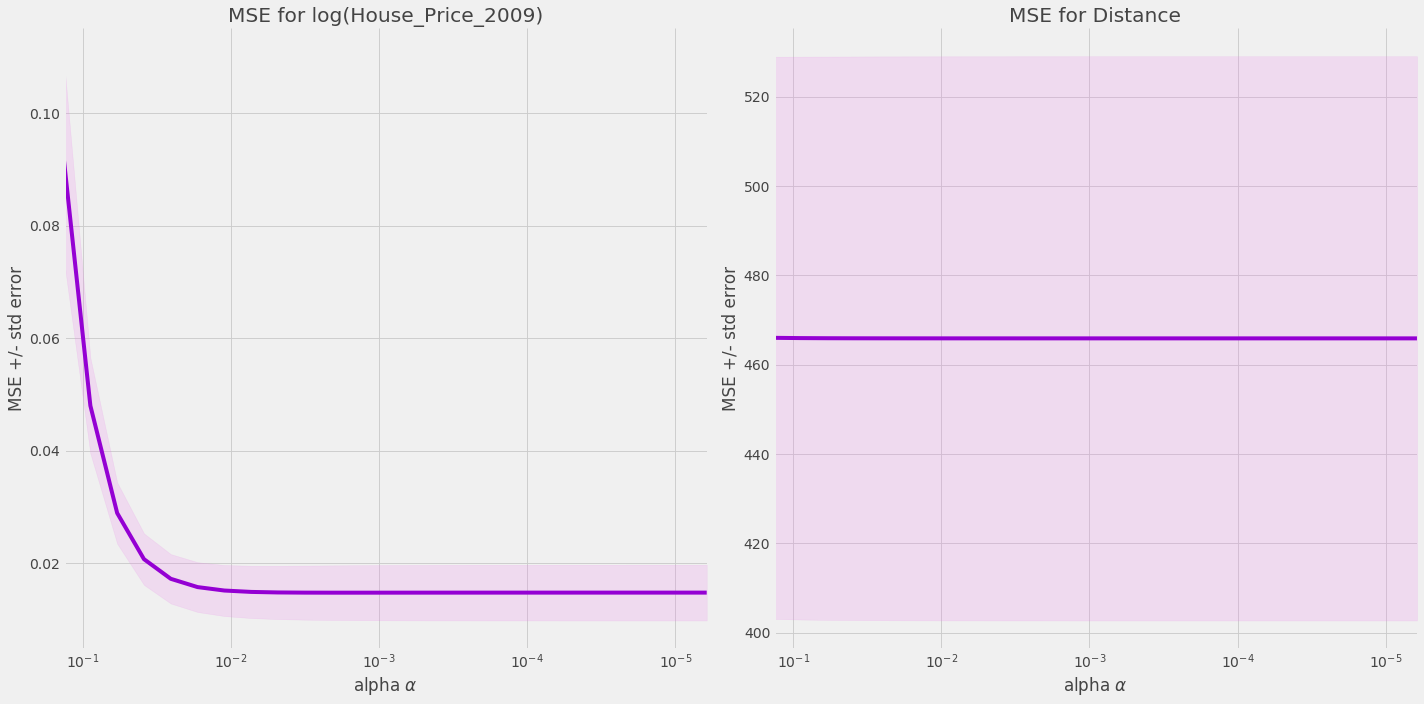

In [68]:
fig, ax = plt.subplots(1, 2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse, color = 'darkviolet')
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2, color = 'violet')

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel(r'alpha $\alpha$')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(House_Price_2009)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for Distance")
fig.tight_layout()

# goal of regression is not prediction so smaller regularization parameter is chosen
#again the choice of regularization is arbitrary. 
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

We can see that the minimized MSE regularization parameter for log house price in 2009 is very small $ ~ 10^{-5}$ while the MSE for distance from wildire does not appear to change across regularization parameters. 

In [69]:
# show results
pl_lasso = partial_linear(loghousepricenine, distance, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
print(pl_lasso[0].summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              18.17
Date:                Thu, 24 Dec 2020   Prob (F-statistic):                    2.10e-05
Time:                        16:19:07   Log-Likelihood:                          1440.5
No. Observations:                2222   AIC:                                     -2879.
Df Residuals:                    2221   BIC:                                     -2873.
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

<Figure size 1440x720 with 0 Axes>

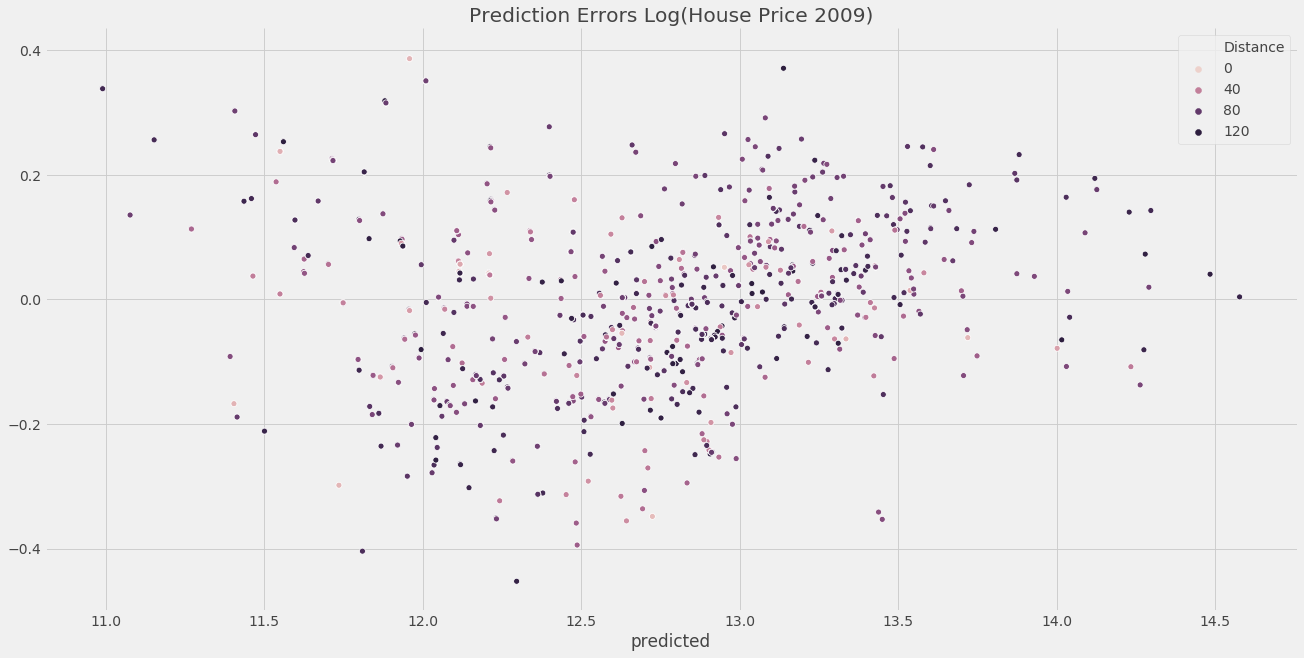

<Figure size 1440x720 with 0 Axes>

In [70]:
# Visualize predictions
pl = pl_lasso

df = pd.DataFrame({"loghouseprice":loghousepricenine,
                    "predicted":pl[1],
                    "Distance":distance,
                    "P(Distance|x)":pl[2]})

sns.scatterplot(df.predicted, df.loghouseprice-df.predicted, hue=df.Distance)
plt.title("Prediction Errors Log(House Price 2009)")

plt.figure()

We can see in the regression that our lasso partially linear model is statistcally significant, but the effect is very small and goes in the opposite direction in comparison to the literature (see, for example, Loomis, 2004, Mueller & Loomis, 2014). Our results tell us that for a unit increase in house kilometer away from a wildfire there is a 0.005 percentage point reduction in house prices in 2009. 

We can also see in the plot above that our model was not great at predicting house prices in 2009 as the prediction error varies a lot by looking at how the points are mostly scattered across the graph.

In [71]:
reg_quant = smf.quantreg('HousePriceNine ~ Distance', reg_data_log)
result = reg_quant.fit(q = 0.5)

In [72]:
print(f"MSE total for the lasso partially linear regression is {pl_lasso[0].mse_total}")
print(f"MSE residual for the lasso partially linear regression is {pl_lasso[0].mse_resid}")
print(f"MSE total for the log OLS linear regression is {results.mse_total}")
print(f"MSE residual for the log OLS linear regression is {results.mse_resid}")
print(f"MSE residual for the log quantile regression is {result.mse_resid}")

MSE total for the lasso partially linear regression is 0.01613096384950106
MSE residual for the lasso partially linear regression is 0.016019016835468147
MSE total for the log OLS linear regression is 0.2900960351742347
MSE residual for the log OLS linear regression is 0.013601627206589579
MSE residual for the log quantile regression is 0.28993826764143305


In comparing the models we can clearly see that the MSE total is the smallest for the partially linear regression model and it has the best fit and most precise estimates, dispite the sign of the estimate being inconsistent with the literature. However, even with the partially linear model the effect is negligible (i.e. very small).

## Conclusion

This project could not find a significant effect of 2008 wildfire proximity on house prices in 2009 in California. Future research would include adding more features to the dataset to minimize the risk of multicollinearity between the independent (e.g. 2007 house prices) and dependent variables. In addition, looking at the effect overtime would prove a fruitful avenue of research as it would be possible to control for variations over time with time fixed effects. This project did find that the lasso partially linear regression model with cross-validation provided more precise estimates than the OLS and quantile regression methods commonly used in the literature. However, further investigation into the choice of the regularization parameter $\alpha$ would need to be done to ensure the technical conditions are met such that our estimate $\hat{\theta}$ is consistent and asymptotically normal.

## References

**Papers**
   
Loomis, J. (2004). Do nearby forest fires cause a reduction in residential property values?. Journal of forest economics, 10(3), 149-157.

Mueller, J. M., & Loomis, J. B. (2014). Does the estimated impact of wildfires vary with the housing price distribution? A quantile regression approach. Land Use Policy, 41, 121-127.

Stetler, K. M., Venn, T. J., & Calkin, D. E. (2010). The effects of wildfire and environmental amenities on property values in northwest Montana, USA. Ecological Economics, 69(11), 2233-2243.

**Data** 

Bureau, U. (2020, March 12). TIGER/Line Shapefiles. Retrieved December 24, 2020, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

Housing Data - Zillow Home Value Index (ZHVI) (SFR, Condo/Coop), Time Series, Smoothed, Seasonally Adjusted ($). (2020, October 31). Retrieved December 24, 2020, from https://www.zillow.com/research/data/

Short, Karen C. 2017. Spatial wildfire occurrence data for the United States, 1992-2015 FPAFOD20170508. 4th Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2013-0009.4

**Online Resources**

Batista, Q., Ruhl, K., Sargent, T., Schrimpf, P., Sood, A., Stachurski, A., . . . Perla, J. (2020). QuantEcon DataScience. Retrieved December 24, 2020, from https://datascience.quantecon.org/

Bubble Maps in Python. (2020). Retrieved December 24, 2020, from https://plotly.com/python/bubble-maps/

Mahon, A. (2018, January 30). Predicting Wildfires. Retrieved December 24, 2020, from https://www.andrewmahon.info/blog/predicting-wildfires-1

Quantile regression. (2020). Retrieved December 24, 2020, from https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
